# Risk Management with Copulas

### Summary:
Find best models for each returns series and extract residuals  
Find best Copula and simulate 1-day returns  
Add AR/GARCH effects back in  
Calculate 1-day VaR  

In [13]:
library(quantmod)

get_returns <- function(ticker) {
  prices_data <- getSymbols(ticker, src = "yahoo", auto.assign = FALSE)

  adj_close <- as.data.frame(Ad(prices_data))
  adj_close$Date <- as.Date(rownames(adj_close))
  colnames(adj_close) <- c("Adj.Close", "Date")

  adj_close$Adj.Close <- as.numeric(adj_close$Adj.Close)

  adj_close$log_returns <- c(NA, diff(log(adj_close$Adj.Close)))
  
  adj_close <- adj_close[adj_close$Date <= as.Date('2024-04-01'),]

  return(adj_close)
}

In [14]:
df <- get_returns("^N225")
df <- df[, c("Date", "log_returns")]
head(df)

Warning message:
"^N225 contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


,Date,log_returns
,<date>,<dbl>
2007-01-04,2007-01-04,NA
2007-01-05,2007-01-05,-0.015217486
2007-01-09,2007-01-09,0.008516359
2007-01-10,2007-01-10,-0.017283501
2007-01-11,2007-01-11,-0.006171050
2007-01-12,2007-01-12,0.012912921


In [15]:
df2 <- get_returns("^GDAXI")
df2 <- df2[, c("Date", "log_returns")]
tail(df2)

Warning message:
"^GDAXI contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


,Date,log_returns
,<date>,<dbl>
2024-03-21,2024-03-21,0.0090688257
2024-03-22,2024-03-22,0.0014670506
2024-03-25,2024-03-25,0.0030367596
2024-03-26,2024-03-26,0.0067150939
2024-03-27,2024-03-27,0.0050318399
2024-03-28,2024-03-28,0.0008331386


In [16]:
merged_df <- merge(df, df2, by = "Date", all = FALSE, suffixes = c("_n225", "_gdaxi"))
head(merged_df)

,Date,log_returns_n225,log_returns_gdaxi
,<date>,<dbl>,<dbl>
1,2007-01-04,NA,-0.002531840
2,2007-01-05,-0.015217486,-0.012257191
3,2007-01-09,0.008516359,0.001025608
4,2007-01-10,-0.017283501,-0.007254460
5,2007-01-11,-0.006171050,0.018220064
6,2007-01-12,0.012912921,0.002668683


In [17]:
merged_df <- na.omit(merged_df)

In [18]:
head(merged_df)

,Date,log_returns_n225,log_returns_gdaxi
,<date>,<dbl>,<dbl>
2,2007-01-05,-0.015217486,-0.012257191
3,2007-01-09,0.008516359,0.001025608
4,2007-01-10,-0.017283501,-0.007254460
5,2007-01-11,-0.006171050,0.018220064
6,2007-01-12,0.012912921,0.002668683
7,2007-01-15,0.008924708,0.003954830


#### ACF plots display correlation with lagged series
#### PACF plots also display correlation with lags but controls for other lags eg autocorrelation between z_t and z_(t+k) that is not accounted for by lags 1 - k-1

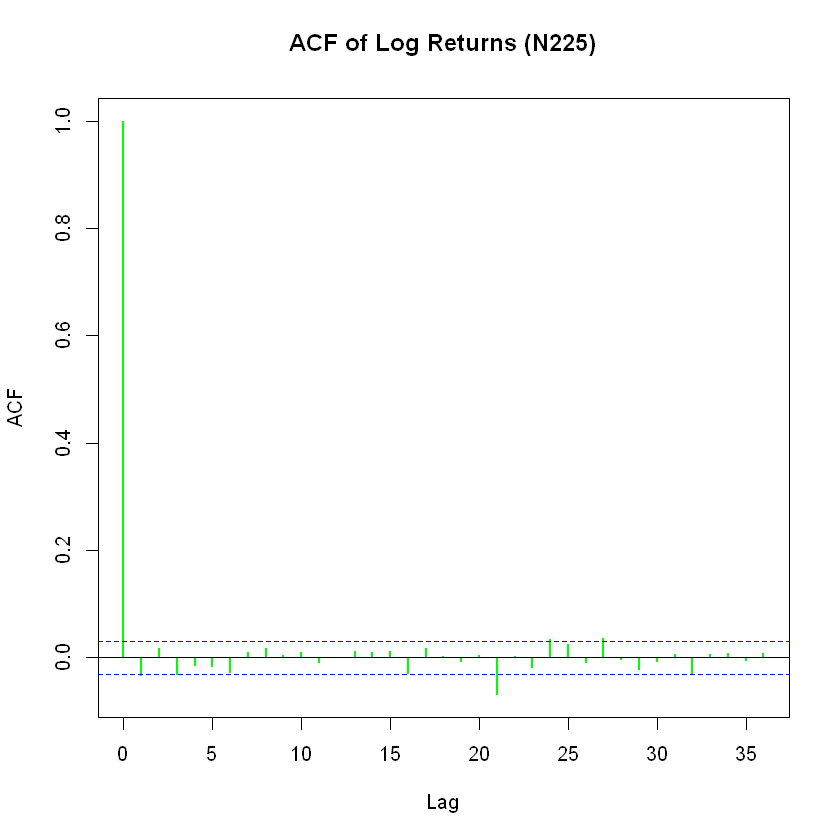

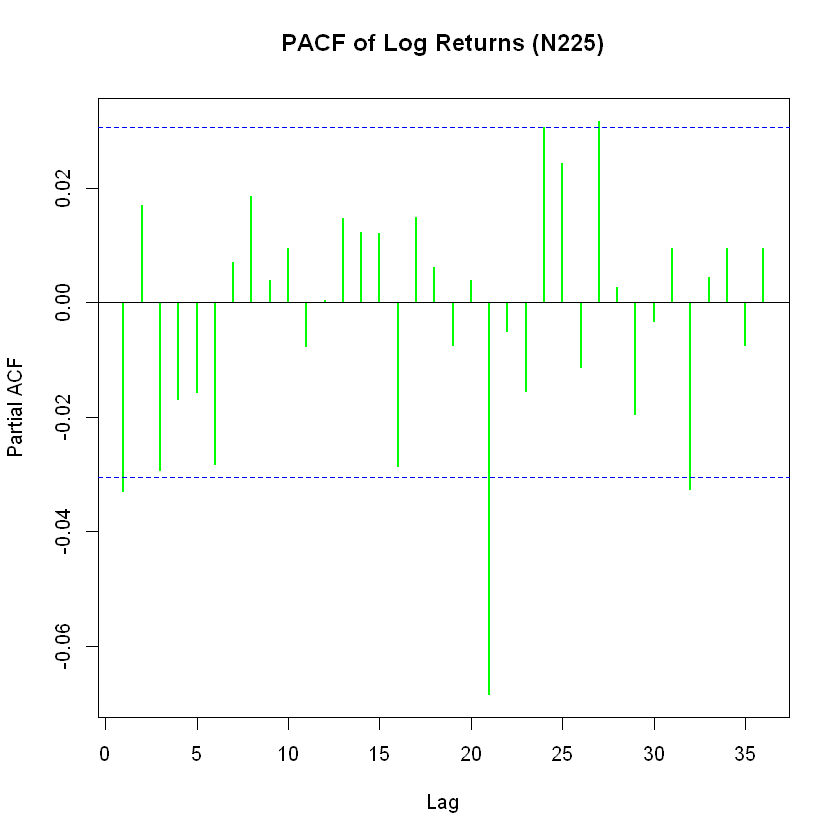

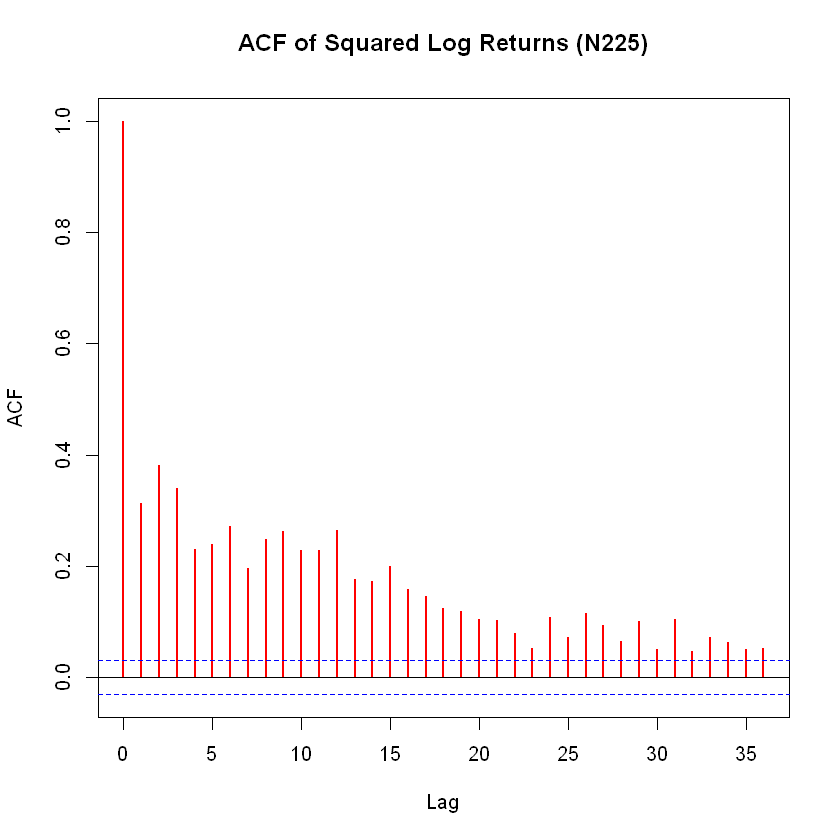

In [19]:
acf(merged_df$log_returns_n225, col="green", lwd=2, main="ACF of Log Returns (N225)") 
pacf(merged_df$log_returns_n225, col="green", lwd=2, main="PACF of Log Returns (N225)")  
acf(merged_df$log_returns_n225^2, col="red", lwd=2, main="ACF of Squared Log Returns (N225)") 

In [20]:
install.packages("tseries")
library(tseries)
adf_test <- adf.test(merged_df$log_returns_n225, alternative = "stationary")
print(adf_test)

Warning message:
"package 'tseries' is in use and will not be installed"
Warning message in adf.test(merged_df$log_returns_n225, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  merged_df$log_returns_n225
Dickey-Fuller = -16.106, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary



In [21]:
box_test <- function(vals) {
  result1 <- Box.test(vals, lag = 10, type = c("Ljung-Box"))
  result2 <- Box.test(vals^2, lag = 10, type = c("Ljung-Box"))
  return(list(result1, result2))
}
#Ljung-Box Test tests for autocorrelation at specific lags

box_test(merged_df$log_returns_n225)

[[1]]

	Box-Ljung test

data:  vals
X-squared = 16.69, df = 10, p-value = 0.08151


[[2]]

	Box-Ljung test

data:  vals^2
X-squared = 3133.4, df = 10, p-value < 2.2e-16



##### Results suggest use of GARCH but not ARMA

In [10]:
library(VineCopula)
install.packages("fGarch")
library(fGarch)
install.packages("KScorrect")
library(KScorrect)
library(stats)
install.packages("ADGofTest")
library(ADGofTest)

Warning message:
"package 'VineCopula' was built under R version 4.3.3"


Installing package into 'C:/Users/zakit/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'fGarch' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'fGarch'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\zakit\AppData\Local\R\win-library\4.3\00LOCK\fGarch\libs\x64\fGarch.dll to C:\Users\zakit\AppData\Local\R\win-library\4.3\fGarch\libs\x64\fGarch.dll: Permission denied"
Warning message:
"restored 'fGarch'"



The downloaded binary packages are in
	C:\Users\zakit\AppData\Local\Temp\RtmpUJQYwB\downloaded_packages


Warning message:
"package 'fGarch' was built under R version 4.3.3"
NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")


Attaching package: 'fGarch'


The following object is masked from 'package:TTR':

    volatility


Installing package into 'C:/Users/zakit/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'KScorrect' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zakit\AppData\Local\Temp\RtmpUJQYwB\downloaded_packages


Warning message:
"package 'KScorrect' was built under R version 4.3.3"
Installing package into 'C:/Users/zakit/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'ADGofTest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zakit\AppData\Local\Temp\RtmpUJQYwB\downloaded_packages


##### Trialling different GARCH models for the Nikkei 225 Returns - we test all possible combinations for 0 < p,q < 4 and all possible conditional distributions

AIC -  
BIC - 


In [24]:
distributions <- c("norm", "snorm", "std", "sstd", "ged", "sged") # Possible distributions
best_model_n225 <- NULL
min_BIC <- Inf # Initialize to a very high value

#R is such a weird programming language
for (dist in distributions) {
    for (p in 1:2) {
        for (q in 1:2) {
            # Dynamically create the formula
            formula <- as.formula(paste("~garch(", p, ",", q, ")", sep = ""))
            
            # Attempt to fit the model
            model <- tryCatch(
                garchFit(formula = formula, data = merged_df$log_returns_n225, trace = FALSE, cond.dist = dist),
                error = function(e) NULL
            )
            
            if (!is.null(model)) {
                current_BIC <- model@fit$ics["BIC"] # Extract BIC - better than AIC
                print(paste("Distribution:", dist, "p:", p, "q:", q, "AIC:", current_BIC))
                
                # Check if the current model has a lower AIC
                if (current_BIC < min_BIC) {
                    min_BIC <- current_BIC
                    best_model_n225 <- model
                }
            }
        }
    }
}



[1] "Distribution: norm p: 1 q: 1 AIC: -5.88568555612171"
[1] "Distribution: norm p: 1 q: 2 AIC: -5.88368078994067"
[1] "Distribution: norm p: 2 q: 1 AIC: -5.88367755008206"
[1] "Distribution: norm p: 2 q: 2 AIC: -5.88176816602126"
[1] "Distribution: snorm p: 1 q: 1 AIC: -5.89563868312851"
[1] "Distribution: snorm p: 1 q: 2 AIC: -5.89367014009869"
[1] "Distribution: snorm p: 2 q: 1 AIC: -5.8936275849595"
[1] "Distribution: snorm p: 2 q: 2 AIC: -5.89159974349944"
[1] "Distribution: std p: 1 q: 1 AIC: -5.91442778372076"
[1] "Distribution: std p: 1 q: 2 AIC: -5.91242066631299"
[1] "Distribution: std p: 2 q: 1 AIC: -5.91243195702532"
[1] "Distribution: std p: 2 q: 2 AIC: -5.91055090665244"
[1] "Distribution: sstd p: 1 q: 1 AIC: -5.91718481199502"
[1] "Distribution: sstd p: 1 q: 2 AIC: -5.91517362407888"
[1] "Distribution: sstd p: 2 q: 1 AIC: -5.91517283780135"
[1] "Distribution: sstd p: 2 q: 2 AIC: -5.91319798634901"
[1] "Distribution: ged p: 1 q: 1 AIC: -5.91766367602277"
[1] "Distributio

In [25]:
# Print the best model summary
if (!is.null(best_model_n225)) {
    print(best_model_n225)
} else {
    cat("No valid model was found.\n")
}


Title:
 GARCH Modelling 

Call:
 garchFit(formula = formula, data = merged_df$log_returns_n225, 
    cond.dist = dist, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(1, 1)
<environment: 0x000002cce9d10558>
 [data = merged_df$log_returns_n225]

Conditional Distribution:
 sged 

Coefficient(s):
        mu       omega      alpha1       beta1        skew       shape  
3.8883e-04  5.2301e-06  1.1674e-01  8.5831e-01  9.1674e-01  1.4241e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
mu     3.888e-04   1.742e-04    2.232   0.0256 *  
omega  5.230e-06   1.163e-06    4.497  6.9e-06 ***
alpha1 1.167e-01   1.364e-02    8.561  < 2e-16 ***
beta1  8.583e-01   1.623e-02   52.886  < 2e-16 ***
skew   9.167e-01   1.824e-02   50.263  < 2e-16 ***
shape  1.424e+00   4.603e-02   30.940  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 12150.58    normalized:  2.966451 

Description:
 Mon D

In [26]:
print(best_model_n225@fit$ics[1])
print(best_model_n225@fit$ics[2])
print(best_model_n225@fit$ics[3])

      AIC 
-5.929972 
      BIC 
-5.920717 
      SIC 
-5.929976 


##### Calculate Residuals between modelled returns and original

In [52]:
res_n225 <- residuals(best_model_n225, standardize = TRUE) #when modelling dependency with Copulas, we need to remove ARCH/GARCH effects because otherwise the observed dependence might be partly driven by changing volatility

In [28]:
print("Autocorrelation/ARCH effect tests for residuals (N225):")  
print(box_test(res_n225)) #autocorrelation effects removed

[1] "Autocorrelation/ARCH effect tests for residuals (N225):"
[[1]]

	Box-Ljung test

data:  vals
X-squared = 6.8248, df = 10, p-value = 0.7419


[[2]]

	Box-Ljung test

data:  vals^2
X-squared = 14.5, df = 10, p-value = 0.1514




#### Probability Integral Transform: for rv X with given distribution, then F_x (X) ~ U(0,1)

In [29]:
model_coefs_n225 <- best_model_n225@fit$coef

In [30]:
# u_n225 <- psstd(res_n225, nu = model_coefs["shape"], xi = model_coefs["skew"])
u_n225 <- psged(res_n225, nu = model_coefs_n225["shape"], xi = model_coefs_n225["skew"])

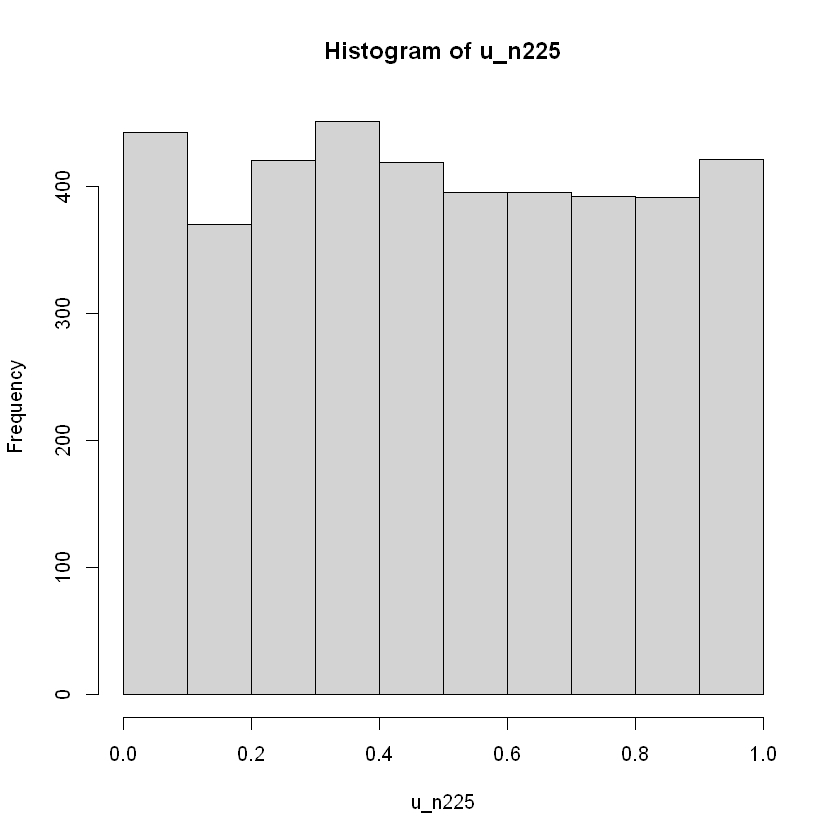

In [31]:
hist(u_n225) #should look uniform

##### Other Uniformity Tests

In [32]:
KStest2 <- LcKS(u_n225, cdf = "punif")
print("Kolmogorov-Smirnov test")
print(KStest2$p.value)

ADtest2 <- ad.test(u_n225, null = "punif")
print("Anderson-Darling test")
print(ADtest2$p.value)

[1] "Kolmogorov-Smirnov test"
[1] 0.1066
[1] "Anderson-Darling test"
       AD 
0.2236961 


##### Doing the same for GDAXI

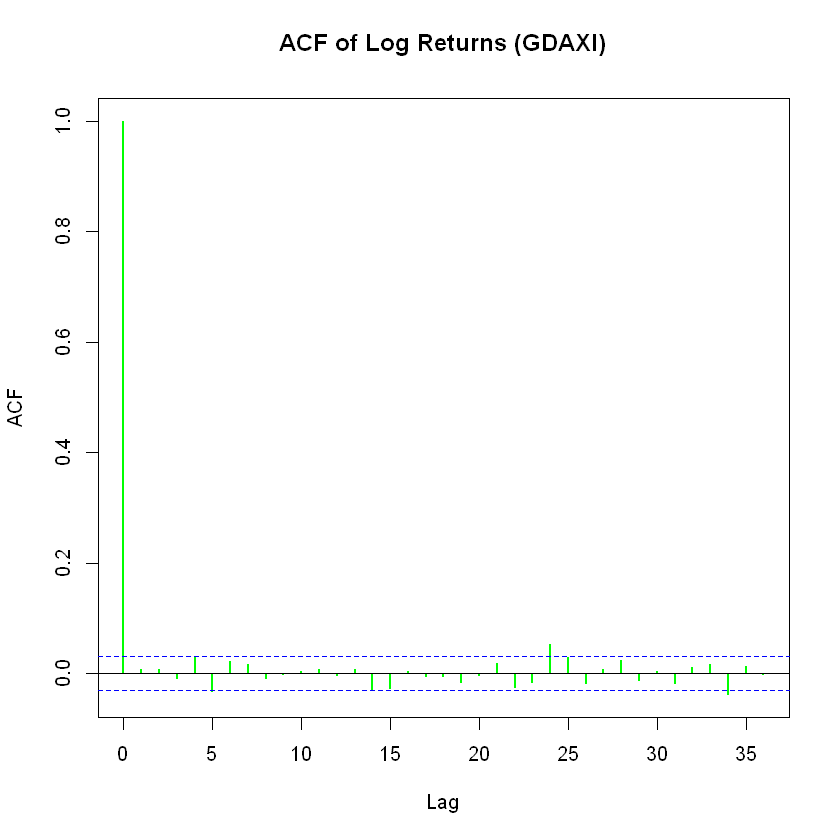

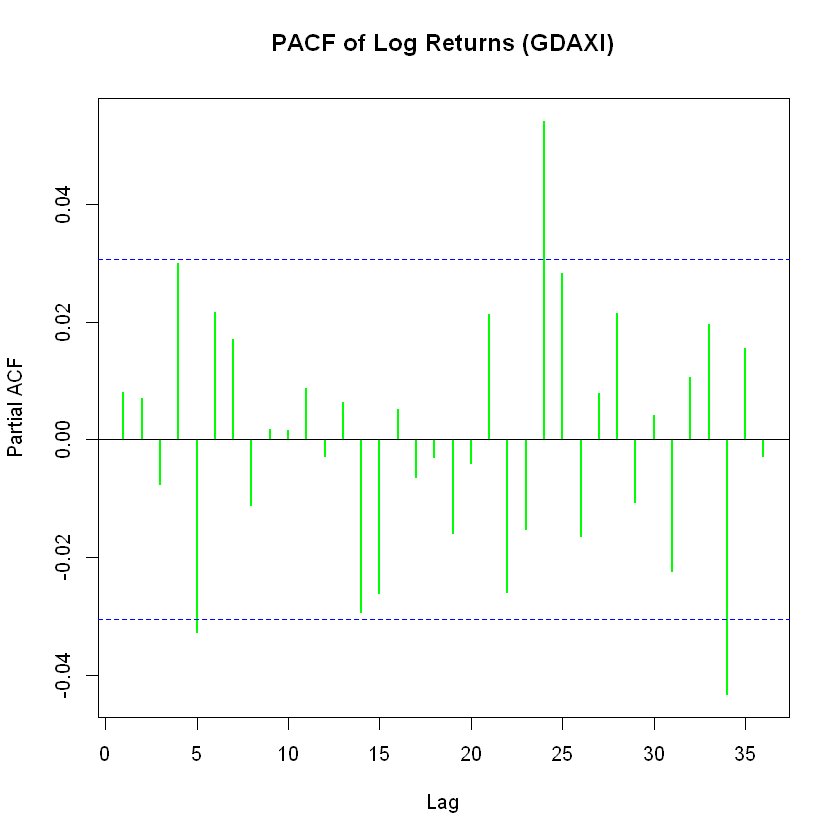

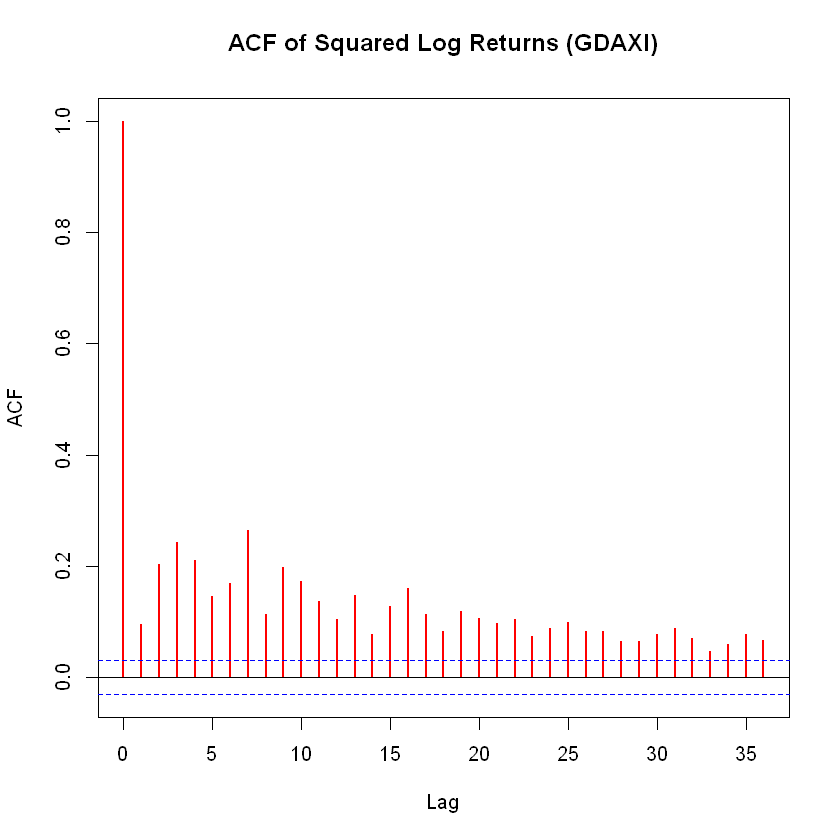

In [33]:
acf(merged_df$log_returns_gdaxi, col="green", lwd=2, main="ACF of Log Returns (GDAXI)") 
pacf(merged_df$log_returns_gdaxi, col="green", lwd=2, main="PACF of Log Returns (GDAXI)")  
acf(merged_df$log_returns_gdaxi^2, col="red", lwd=2, main="ACF of Squared Log Returns (GDAXI)") 

In [ ]:
box_test <- function(vals) {
  result1 <- Box.test(vals, lag = 10, type = c("Ljung-Box"))
  result2 <- Box.test(vals^2, lag = 10, type = c("Ljung-Box"))
  return(list(result1, result2))
}
#Ljung-Box Test tests for autocorrelation at specific lags

box_test(merged_df$log_returns_gdaxi) #only conditional heteroscedasticity present

[[1]]

	Box-Ljung test

data:  vals
X-squared = 12.103, df = 10, p-value = 0.2782


[[2]]

	Box-Ljung test

data:  vals^2
X-squared = 1459.4, df = 10, p-value < 2.2e-16



In [35]:
distributions <- c("norm", "snorm", "std", "sstd", "ged", "sged") # Possible distributions
best_model_gdaxi <- NULL
min_BIC_gdaxi <- Inf # Initialize to a very high value

#R is such a weird programming language
for (dist in distributions) {
    for (p in 1:2) {
        for (q in 1:2) {
            # Dynamically create the formula
            formula <- as.formula(paste("~garch(", p, ",", q, ")", sep = ""))
            
            # Attempt to fit the model
            model <- tryCatch(
                garchFit(formula = formula, data = merged_df$log_returns_gdaxi, trace = FALSE, cond.dist = dist),
                error = function(e) NULL
            )
            
            if (!is.null(model)) {
                current_BIC <- model@fit$ics["BIC"] # Extract BIC - better for true model fit than AIC
                print(paste("Distribution:", dist, "p:", p, "q:", q, "BIC:", current_BIC))
                
                # Check if the current model has a lower BIC
                if (current_BIC < min_BIC) {
                    min_BIC_gdaxi <- current_BIC
                    best_model_gdaxi <- model
                }
            }
        }
    }
}




[1] "Distribution: norm p: 1 q: 1 BIC: -6.07416555713504"
[1] "Distribution: norm p: 1 q: 2 BIC: -6.07212037910302"
[1] "Distribution: norm p: 2 q: 1 BIC: -6.07297009837499"
[1] "Distribution: norm p: 2 q: 2 BIC: -6.07096678486694"
[1] "Distribution: snorm p: 1 q: 1 BIC: -6.08320003733693"
[1] "Distribution: snorm p: 1 q: 2 BIC: -6.08115070337288"
[1] "Distribution: snorm p: 2 q: 1 BIC: -6.08206902105026"
[1] "Distribution: snorm p: 2 q: 2 BIC: -6.08007987320661"
[1] "Distribution: std p: 1 q: 1 BIC: -6.12924522302118"
[1] "Distribution: std p: 1 q: 2 BIC: -6.1272137879663"
[1] "Distribution: std p: 2 q: 1 BIC: -6.1281793601589"
[1] "Distribution: std p: 2 q: 2 BIC: -6.12626365936546"
[1] "Distribution: sstd p: 1 q: 1 BIC: -6.1321251937721"
[1] "Distribution: sstd p: 1 q: 2 BIC: -6.13008742902281"
[1] "Distribution: sstd p: 2 q: 1 BIC: -6.13116001690133"
[1] "Distribution: sstd p: 2 q: 2 BIC: -6.12925340863167"
[1] "Distribution: ged p: 1 q: 1 BIC: -6.13261855383721"
[1] "Distribution:

In [36]:
res_gdaxi <- residuals(best_model_gdaxi, standardize = TRUE)
print("Autocorrelation/ARCH effect tests for residuals (GDAXI):")  
print(box_test(res_gdaxi))

[1] "Autocorrelation/ARCH effect tests for residuals (GDAXI):"


[[1]]

	Box-Ljung test

data:  vals
X-squared = 5.0562, df = 10, p-value = 0.8874


[[2]]

	Box-Ljung test

data:  vals^2
X-squared = 7.8309, df = 10, p-value = 0.6454




In [37]:
best_model_gdaxi


Title:
 GARCH Modelling 

Call:
 garchFit(formula = formula, data = merged_df$log_returns_gdaxi, 
    cond.dist = dist, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(2, 2)
<environment: 0x000002cce973c600>
 [data = merged_df$log_returns_gdaxi]

Conditional Distribution:
 sged 

Coefficient(s):
        mu       omega      alpha1      alpha2       beta1       beta2  
4.9190e-04  3.8707e-06  6.2816e-02  7.1469e-02  6.7175e-01  1.7401e-01  
      skew       shape  
9.1253e-01  1.2699e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
mu     4.919e-04   1.572e-04    3.129  0.00175 ** 
omega  3.871e-06   1.271e-06    3.045  0.00233 ** 
alpha1 6.282e-02   2.111e-02    2.976  0.00292 ** 
alpha2 7.147e-02   3.828e-02    1.867  0.06191 .  
beta1  6.718e-01   3.133e-01    2.144  0.03204 *  
beta2  1.740e-01   2.792e-01    0.623  0.53313    
skew   9.125e-01   1.611e-02   56.661  < 2e-16 ***
shape  1.270e+00   3.862e-02   32.879

In [38]:
model_coefs_gdaxi <- best_model_gdaxi@fit$coef

In [39]:
# u_n225 <- psstd(res_n225, nu = model_coefs["shape"], xi = model_coefs["skew"])
u_gdaxi <- psged(res_gdaxi, nu = model_coefs_gdaxi["shape"], xi = model_coefs_gdaxi["skew"])

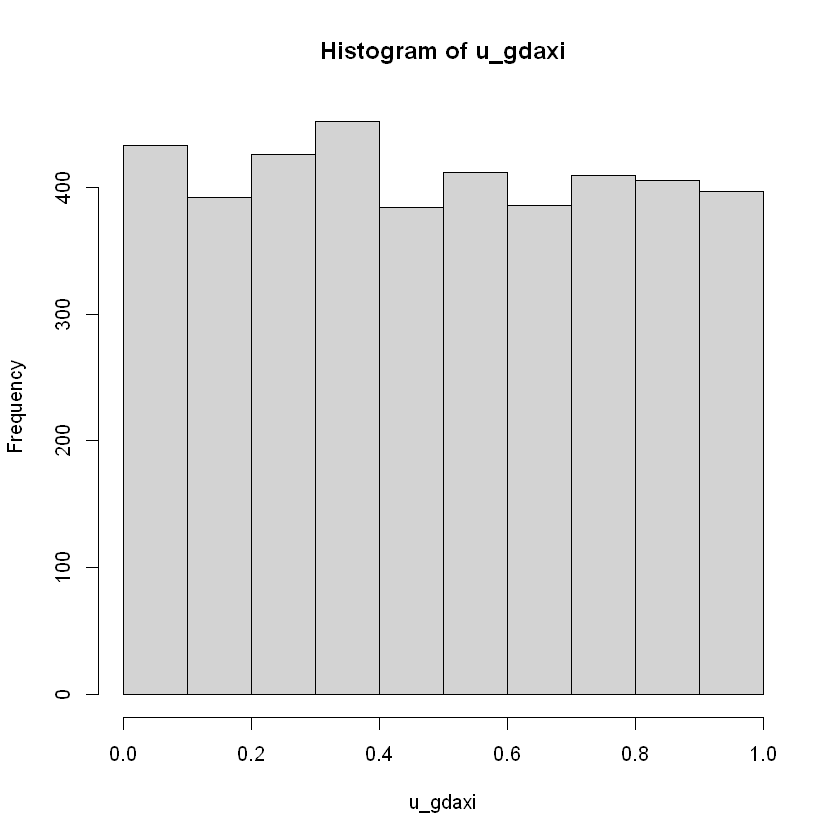

In [40]:
hist(u_gdaxi)

In [41]:
KStest2 <- LcKS(u_gdaxi, cdf = "punif")
print("Kolmogorov-Smirnov test")
print(KStest2$p.value)

ADtest2 <- ad.test(u_gdaxi, null = "punif")
print("Anderson-Darling test")
print(ADtest2$p.value)

[1] "Kolmogorov-Smirnov test"
[1] 0.1372
[1] "Anderson-Darling test"
       AD 
0.2045575 


##### Choosing the best Copula for dependency modelling

In [42]:
Copula <- BiCopSelect(u_gdaxi, u_n225, se = TRUE)  # se = standard error
Copula

Bivariate copula: BB1 (par = 0.24, par2 = 1.08, tau = 0.17) 

##### The Copula marginals are uniform, thus to get the original modelled marginals we apply inverse cumulative distribution function/quantile function (in this case both are qsged)

In [ ]:
set.seed(10)
CopulaSim <- BiCopSim(10000, family = Copula$family, Copula$par, Copula$par2) #nu = shape, xi=skew
res_gdaxi_sim <- qsged(CopulaSim[,1], nu = model_coefs_gdaxi['shape'], xi = model_coefs_gdaxi['skew']) #marginal distributions - represent epsilon
res_n225_sim <- qsged(CopulaSim[,2], nu = model_coefs_n225['shape'], xi = model_coefs_n225['skew']) 

## Simulating 1-day VaR based on Equally Weighted Portfolio of both indices

#### Reintroducing GARCH effects for Nikkei 225

In [44]:
n225_sigmas <- best_model_n225@sigma.t
n225_res <- best_model_n225@residuals
n225_model_args <- best_model_n225@fit$par

alpha = coefficient of residual term  
beta = coefficient of volatility term (see GARCH.png)

In [51]:
#take the model arguments and multiply by 1, u_(t-1)^2 and sigma_(t-1)^2 , then sum, as in the equation in GARCH.png

n225_sigma_t <- sum (n225_model_args[c('omega', 'alpha1', 'beta1')] * c(1, tail(n225_res^2, 1), tail(n225_sigmas^2, 1))) #new sigma term

In [46]:
best_model_n225


Title:
 GARCH Modelling 

Call:
 garchFit(formula = formula, data = merged_df$log_returns_n225, 
    cond.dist = dist, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(1, 1)
<environment: 0x000002cce9d10558>
 [data = merged_df$log_returns_n225]

Conditional Distribution:
 sged 

Coefficient(s):
        mu       omega      alpha1       beta1        skew       shape  
3.8883e-04  5.2301e-06  1.1674e-01  8.5831e-01  9.1674e-01  1.4241e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
mu     3.888e-04   1.742e-04    2.232   0.0256 *  
omega  5.230e-06   1.163e-06    4.497  6.9e-06 ***
alpha1 1.167e-01   1.364e-02    8.561  < 2e-16 ***
beta1  8.583e-01   1.623e-02   52.886  < 2e-16 ***
skew   9.167e-01   1.824e-02   50.263  < 2e-16 ***
shape  1.424e+00   4.603e-02   30.940  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 12150.58    normalized:  2.966451 

Description:
 Mon D

In [ ]:
const_term <- n225_model_args['mu']
print(const_term)
n225_pred <- const_term + n225_sigma_t^(0.5)*res_n225_sim #final equation is just mu plus u=sigma*epsilon
n225_pred

          mu 
0.0003888275 


[1] -3.815637e-03  5.558848e-03 -1.331804e-02 -7.155583e-03  2.467571e-04
    [6]  3.675053e-03 -1.262760e-04 -1.529151e-03 -1.344155e-02  1.038215e-02
   [11]  6.439337e-03 -6.289522e-04  5.813364e-03 -3.669160e-03 -6.499876e-04
   [16] -1.343551e-02  1.198647e-02  7.183589e-03  2.196067e-02  2.312762e-03
   [21] -8.808010e-03 -6.677284e-04 -1.234044e-02 -8.799041e-03  5.945103e-03
   [26]  1.661221e-02 -1.437302e-03  7.700218e-04  1.961712e-04  7.081600e-04
   [31] -2.404020e-02 -1.523932e-03  1.046753e-02  4.247406e-04 -1.367260e-02
   [36] -2.885916e-03  2.636047e-03 -4.301951e-03  1.984795e-02 -9.952569e-03
   [41]  2.690314e-03  2.141268e-03 -2.875312e-02 -2.820911e-03 -1.346471e-02
   [46]  6.466386e-03  2.159099e-03  1.020819e-02  3.292742e-04 -1.938621e-02
   [51] -1.853107e-02 -2.002426e-03  1.776905e-02  5.399748e-03  6.188166e-04
   [56]  1.324673e-02 -7.539020e-04  1.673924e-02  7.555227e-03  6.898313e-03
   [61] -8.139719e-03  1.598467e-03 -1.032244e-02 -1.634363e-03  2.193113e-02
   [66] -1.524606e-02 -4.535551e-03 -6.304918e-03  1.362178e-02 -1.545959e-03
   [71] -5.220902e-03  1.224160e-02  7.533001e-03  3.354543e-03  1.050249e-02
   [76] -4.915988e-03 -1.771359e-02 -1.023581e-02 -8.664968e-03 -9.284074e-03
   [81]  2.904861e-03 -1.510058e-03 -3.575611e-03  2.684934e-02  4.317381e-03
   [86]  8.501543e-03  7.963791e-03  4.900040e-03 -1.150234e-02 -2.737304e-03
   [91] -1.306663e-02  1.006704e-04  4.404534e-03  8.357167e-03 -6.802686e-03
   [96] -2.402049e-02 -4.313044e-03  1.953814e-03 -4.297637e-03  9.690530e-03
  [101] -6.709127e-05  1.256470e-02  2.483528e-03  3.996111e-02  1.196078e-02
  [106]  6.672228e-03  6.467797e-04  3.093549e-03  4.178922e-03 -8.615602e-03
  [111]  2.119011e-03  1.127358e-02 -8.217659e-03  8.871291e-03  5.540975e-04
  [116]  3.673152e-04 -4.370421e-03 -2.975583e-03  4.462025e-03  9.551482e-03
  [121]  1.114305e-03 -1.689601e-02  6.400199e-03  1.094601e-02  8.684272e-03
  [126]  1.055251e-02 -6.225155e-03  7.252544e-03 -1.218534e-03  7.413393e-03
  [131] -9.668516e-04  6.024939e-04 -1.131889e-02 -1.583553e-03  1.200624e-02
  [136]  3.028448e-02 -5.193681e-03  3.048031e-02  8.645472e-03 -1.957075e-02
  [141]  2.861238e-02  1.353814e-02  1.671116e-02  5.771112e-03  1.393098e-02
  [146]  2.455547e-02  3.199636e-02  2.550410e-04 -1.021318e-02 -9.176479e-03
  [151] -3.155825e-02  2.688219e-03  9.250737e-03 -4.710760e-03  7.873638e-03
  [156] -1.533541e-02  1.805070e-04 -7.876165e-03 -1.353768e-02 -2.040773e-03
  [161]  4.611398e-03  3.510764e-02 -4.028567e-03 -4.049088e-03  2.005854e-02
  [166]  1.328340e-03 -5.057194e-03  3.380837e-03  7.905287e-03  1.224834e-02
  [171]  5.081389e-03 -1.360344e-02 -1.029577e-02  1.420130e-02  8.445652e-03
  [176]  2.726133e-02  5.390080e-03 -1.227272e-04  1.231994e-02  8.320184e-03
  [181] -3.243952e-03 -3.129234e-03  3.872545e-04 -2.852201e-03  2.142849e-02
  [186]  2.239179e-03 -1.577444e-02  1.376352e-03 -1.895779e-03 -1.526230e-02
  [191] -9.852149e-04  1.299060e-02 -2.953145e-03 -2.438376e-03 -1.464433e-02
  [196]  4.669975e-03  2.235463e-04  3.259030e-03  8.448579e-04  1.219580e-02
  [201]  8.712181e-03  8.538016e-03  7.188292e-04 -4.880008e-03 -8.531186e-03
  [206]  6.932985e-03  5.679204e-03 -3.056337e-02 -1.109200e-02 -4.306367e-03
  [211]  4.345603e-03  1.617864e-02  1.923518e-02  4.391454e-02  5.966839e-03
  [216] -2.173374e-02 -6.601211e-03 -1.988227e-02 -5.572900e-03  1.088733e-02
  [221]  3.258160e-02 -1.208739e-02  4.381763e-03  1.482411e-02 -7.309854e-03
  [226]  1.843370e-02 -2.015708e-02  1.174509e-03 -3.424576e-03 -2.210790e-02
  [231] -7.279008e-03 -7.192249e-03 -3.885236e-03  2.855371e-02  4.090374e-03
  [236]  1.469496e-02 -4.272799e-03 -2.020843e-03 -6.766965e-03 -2.839965e-02
  [241] -7.259290e-03 -4.235866e-03  1.821355e-02  5.719733e-03 -3.279889e-03
  [246] -6.144063e-03 -5.263287e-03 -4.153378e-04 -4.883899e-03  5.822571e-04
  [251]  2.987818e-02 -2.112865e-03 -2.292932e-03 -1.898253e-02  1.325736e-02
  [256]  1.150132e-02 -6.1

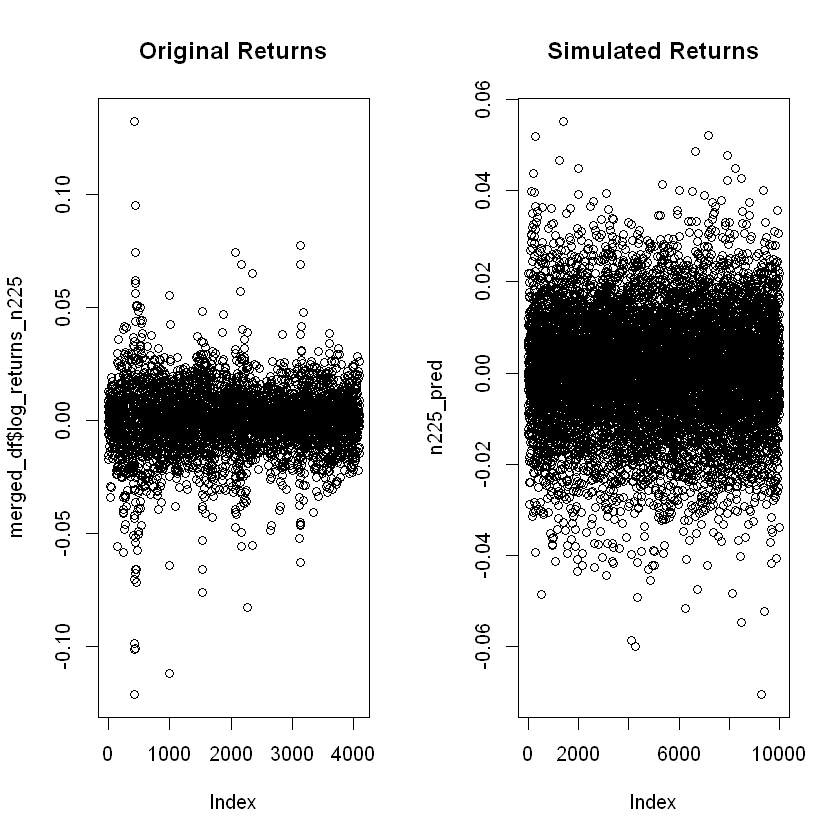

In [48]:
par(mfrow = c(1, 2))
plot(merged_df$log_returns_n225, main="Original Returns")
plot(n225_pred, main="Simulated Returns")

#### Reintroducing GARCH effects for GDAXI

In [49]:
gdaxi_sigmas <- best_model_gdaxi@sigma.t
gdaxi_res <- best_model_gdaxi@residuals
gdaxi_model_args <- best_model_gdaxi@fit$par

In [50]:
gdaxi_sigma_t <- sum (gdaxi_model_args[c('omega', 'alpha1', 'beta1')] * c(1, tail(gdaxi_res^2, 1), tail(gdaxi_sigmas^2, 1)))

In [54]:
const_term_gdaxi <- gdaxi_model_args['mu']
gdaxi_pred <- const_term_gdaxi + gdaxi_sigma_t^(0.5)*res_gdaxi_sim #final equation
gdaxi_pred

[1]  8.723923e-04 -6.235346e-05 -7.408995e-03 -2.259860e-03  2.064259e-03
    [6]  2.496172e-03 -6.206367e-03 -9.641439e-04 -9.409716e-03 -4.166051e-04
   [11]  6.233849e-03  4.302305e-03 -3.260131e-04  5.571203e-03  4.226728e-03
   [16]  1.177924e-03 -4.461711e-03 -1.150575e-04  5.222361e-03  2.933502e-03
   [21] -2.243369e-03 -1.428163e-02 -2.703707e-03 -1.366937e-02 -6.620304e-03
   [26] -1.016485e-03 -2.779415e-03 -3.923139e-03  3.281028e-04 -4.031620e-04
   [31] -1.130934e-02  4.380767e-04  5.464104e-03  1.584662e-03 -7.474112e-03
   [36] -7.898246e-03  2.368993e-03 -1.050386e-02 -7.612301e-04 -2.565652e-03
   [41]  6.144204e-03 -3.234467e-03 -3.646527e-03  4.722268e-03 -4.545788e-03
   [46]  6.611617e-04  1.790767e-03 -6.418936e-04 -2.720074e-03  3.782144e-03
   [51] -1.159030e-03 -8.128151e-04  7.869417e-03  1.331591e-02  3.042999e-03
   [56]  4.464053e-03 -4.116821e-03  3.173999e-03 -2.532260e-03  2.048411e-03
   [61] -6.419349e-03 -1.457788e-03 -3.657004e-03  2.269047e-03  6.026094e-03
   [66]  6.920592e-03  4.196902e-03 -1.594775e-03  3.319908e-03 -6.482682e-03
   [71]  2.455308e-03 -7.859133e-03 -5.089027e-03 -2.288896e-04 -8.320299e-03
   [76]  6.656997e-03 -8.241401e-03 -1.318179e-03 -5.110805e-03  8.878824e-03
   [81]  3.468578e-03 -2.492850e-04  4.078198e-03  4.097434e-03  2.731074e-03
   [86]  1.472925e-03  3.805215e-03  1.396301e-02 -6.033727e-03  4.563845e-04
   [91] -1.242855e-03 -9.728860e-05  1.093135e-03  6.552586e-03  3.479163e-03
   [96] -7.776422e-03 -9.247830e-03  5.041573e-03  1.427495e-03  6.987322e-03
  [101] -3.229909e-03  2.633385e-03 -5.031153e-03  4.071352e-03 -2.457830e-03
  [106]  3.322021e-03  3.811439e-03 -9.665529e-03  5.804463e-03  6.388928e-03
  [111] -6.729910e-03  6.394369e-03 -1.501182e-03 -7.161641e-04  5.215514e-03
  [116]  1.125754e-03  5.872366e-03  4.229327e-03  7.162889e-03  5.364583e-03
  [121] -1.595639e-03  1.662047e-03  6.480239e-04 -6.116803e-03  3.622741e-03
  [126] -4.198597e-03  1.861789e-03 -5.185900e-03 -9.657456e-04 -6.198603e-03
  [131]  8.264126e-03  3.671839e-03 -1.256342e-02 -2.745223e-03 -1.478922e-03
  [136] -4.648289e-03  2.992608e-03  4.145374e-03  3.843616e-03  5.386344e-03
  [141] -9.807339e-03 -6.185616e-03 -1.226532e-02  8.535645e-03  2.416511e-03
  [146]  6.023193e-03  3.163078e-03  1.231696e-03  7.677519e-03  1.168910e-03
  [151] -1.108463e-03 -3.836929e-04  6.551125e-03 -3.875567e-03 -3.888044e-03
  [156] -1.556494e-02  3.548322e-03  6.520563e-03 -6.145559e-03 -9.033224e-03
  [161]  3.771673e-03 -1.975363e-03  3.116546e-03 -2.850439e-03 -1.364142e-03
  [166] -2.718315e-03  5.410881e-03 -8.150732e-03  1.579669e-03 -7.895421e-03
  [171] -5.704481e-03 -1.233711e-03  1.409490e-03  6.000713e-03 -2.096928e-03
  [176]  7.297091e-03  1.772298e-03 -6.806459e-04  5.414760e-03  3.251652e-03
  [181]  2.662041e-03  3.722675e-03 -7.325889e-03 -1.313396e-04  3.600759e-03
  [186]  1.278107e-02 -6.626491e-04  2.005116e-03  3.966716e-03  9.929916e-04
  [191]  1.278513e-03  5.616141e-03 -2.741161e-03 -6.707170e-03 -8.154805e-03
  [196] -7.044637e-04 -1.004120e-02 -7.252307e-03 -5.458035e-03 -5.440342e-03
  [201]  6.916852e-03  2.227256e-03  8.012451e-03  4.926797e-03 -5.310898e-03
  [206]  2.994958e-03  5.946033e-03 -6.689511e-03 -1.078666e-04 -6.839818e-03
  [211]  1.400761e-03  7.201073e-03 -1.324170e-03 -1.104317e-02  2.325484e-03
  [216] -7.236829e-03  4.051222e-03 -1.213650e-03 -1.402759e-03 -5.039399e-03
  [221] -7.853167e-04 -5.487359e-04  2.694410e-03 -6.744915e-04  5.354585e-04
  [226]  4.185534e-03  1.211844e-03  9.611472e-03  3.309423e-03  7.625540e-03
  [231] -5.285812e-04 -6.631519e-03 -3.801189e-04  8.690623e-04  2.437619e-03
  [236]  4.515568e-03 -3.722496e-03 -1.447005e-02 -5.638980e-03 -7.183330e-03
  [241]  9.435189e-03  4.242627e-03  4.872301e-03  2.520932e-03  3.058892e-03
  [246]  2.311035e-04  1.191724e-03 -9.338676e-04 -9.431328e-04  5.806785e-03
  [251]  6.093421e-03  5.257305e-03 -8.093473e-03 -4.141872e-03 -2.736367e-03
  [256]  6.007368e-03 -2.8

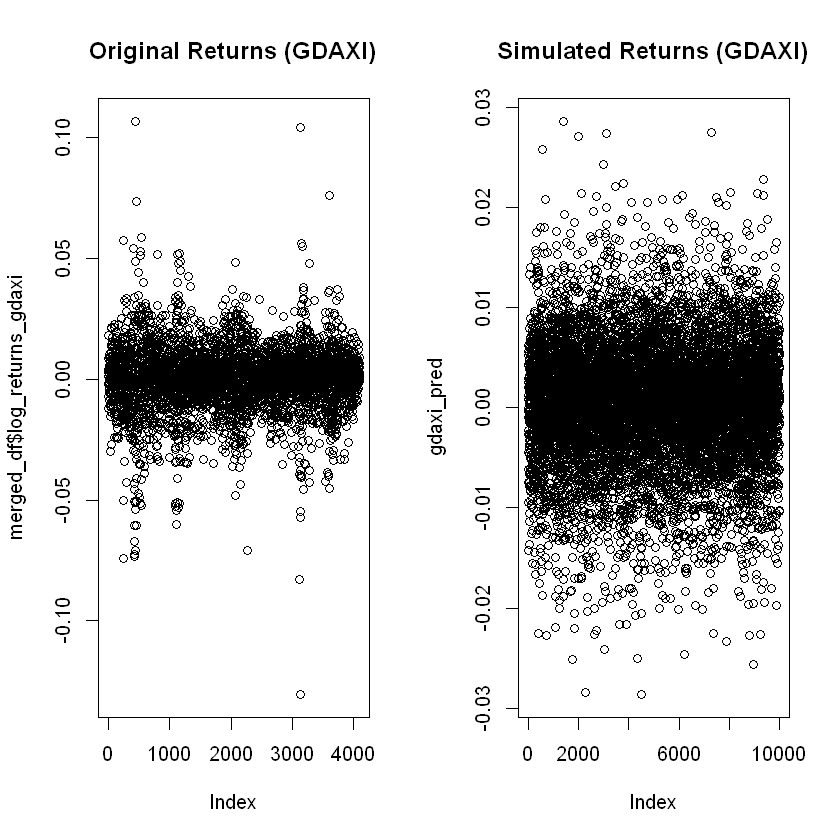

In [55]:
par(mfrow = c(1, 2))
plot(merged_df$log_returns_gdaxi, main="Original Returns (GDAXI)")
plot(gdaxi_pred, main="Simulated Returns (GDAXI)")

In [56]:
SimulatedPortfolio <- log(1 + ((exp(gdaxi_pred) - 1) + (exp(n225_pred) - 1)) * (1/2)) #convert to simple returns, then average and convert back to log returns

In [57]:
SimulatedVAR <- -quantile(SimulatedPortfolio, c(0.01, 0.05))
print("Simulated 99% and 95% VaR:")
print(SimulatedVAR)

[1] "Simulated 99% and 95% VaR:"
        1%         5% 
0.01928685 0.01222135 


The probability of the portfolio suffering a loss of 1.9% in a single day is less than 1%